# Import Libraries

In [1]:
import os
import re
import psycopg2
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import sklearn.metrics as metrics

# Postgres connection

In [2]:
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'mimiciv'

In [3]:
# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

In [4]:
# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

# Get numeric labs with > 95% coverage

In [11]:
top_labs = ["creatinine_x", "urea_nitrogen_x", "potassium_x", "sodium_x", "chloride_x", "hematocrit_x", "bicarbonate", "anion_gap_x", "glucose_y", "platelet_count", "white_blood_cells_x", "hemoglobin_y", "mch", "mchc", "mcv", "rdw", "red_blood_cells", "magnesium", "phosphate", "calcium_total"]

In [7]:
itemidQuery = query_schema + \
"""
SELECT
itm.itemid,
itm.label
FROM mimiciv.labevents lev
INNER JOIN mimiciv.d_labitems itm
ON itm.itemid = lev.itemid
GROUP BY itm.itemid
"""

itemidsDf = pd.read_sql_query(itemidQuery, con)

In [18]:
labels = []
rows = []

for index, row in itemidsDf.iterrows():
    lbl = re.sub("[^a-zA-Z]+", "_", str(row['label'])).lower()
    if (lbl in top_labs) or (lbl + '_x' in top_labs) or (lbl + '_y' in top_labs):
        labels.append(lbl)
        rows.append(row)

# print(type(rows[0]))
topItemidsDf = pd.DataFrame(rows)
# topItemidsDf
topItemidsDf['lbl'] = labels
topItemidsDf

,itemid,label,lbl
7,50809,Glucose,glucose
9,50811,Hemoglobin,hemoglobin
60,50868,Anion Gap,anion_gap
74,50882,Bicarbonate,bicarbonate
84,50893,"Calcium, Total",calcium_total
93,50902,Chloride,chloride
103,50912,Creatinine,creatinine
121,50931,Glucose,glucose
149,50960,Magnesium,magnesium
159,50970,Phosphate,phosphate


# Get data

In [24]:
itemidQuery = query_schema + \
"""
    WITH labs_stg_1 AS
    (
        SELECT adm.hadm_id, lev.charttime, lev.valuenum
        , CASE
                WHEN itemid = 50809 THEN 'glucose'
                WHEN itemid = 50811 THEN 'hemoglobin'
                WHEN itemid = 50868 THEN 'anion_gap'
                WHEN itemid = 50882 THEN 'bicarbonate'
                WHEN itemid = 50893 THEN 'calcium_total'
                WHEN itemid = 50902 THEN 'chloride'
                WHEN itemid = 50912 THEN 'creatinine'
                WHEN itemid = 50931 THEN 'glucose'
                WHEN itemid = 50960 THEN 'magnesium'
                WHEN itemid = 50970 THEN 'phosphate'
                WHEN itemid = 50971 THEN 'potassium'
                WHEN itemid = 50983 THEN 'sodium'
                WHEN itemid = 51006 THEN 'urea_nitrogen'
                WHEN itemid = 51221 THEN 'hematocrit'
                WHEN itemid = 51222 THEN 'hemoglobin'
                WHEN itemid = 51248 THEN 'mch'
                WHEN itemid = 51249 THEN 'mchc'
                WHEN itemid = 51250 THEN 'mcv'
                WHEN itemid = 51265 THEN 'platelet_count'
                WHEN itemid = 51277 THEN 'rdw'
                WHEN itemid = 51279 THEN 'red_blood_cells'
                WHEN itemid = 51301 THEN 'white_blood_cells'
                WHEN itemid = 51478 THEN 'glucose'
                WHEN itemid = 51480 THEN 'hematocrit'
                WHEN itemid = 51638 THEN 'hematocrit'
                WHEN itemid = 51755 THEN 'white_blood_cells'
                WHEN itemid = 51981 THEN 'glucose'
                WHEN itemid = 52500 THEN 'anion_gap'
                WHEN itemid = 52535 THEN 'chloride'
                WHEN itemid = 52546 THEN 'creatinine'
                WHEN itemid = 52569 THEN 'glucose'
                WHEN itemid = 52610 THEN 'potassium'
                WHEN itemid = 52623 THEN 'sodium'
                WHEN itemid = 52647 THEN 'urea_nitrogen'
            ELSE null
            END AS label
        FROM mimiciv.admissions adm
        INNER JOIN mimiciv.icustays icu
        ON icu.hadm_id = adm.hadm_id
        INNER JOIN mimiciv.labevents lev
        ON lev.hadm_id = adm.hadm_id
        AND lev.charttime >= adm.admittime
        AND lev.charttime <= adm.admittime + interval '48 hour'
        WHERE lev.itemid IN
        (
            50809,
            50811,
            50868,
            50882,
            50893,
            50902,
            50912,
            50931,
            50960,
            50970,
            50971,
            50983,
            51006,
            51221,
            51222,
            51248,
            51249,
            51250,
            51265,
            51277,
            51279,
            51301,
            51478,
            51480,
            51638,
            51755,
            51981,
            52500,
            52535,
            52546,
            52569,
            52610,
            52623,
            52647
        )
        AND valuenum IS NOT null
    )
    , labs_stg_2 AS
    (
    SELECT
        hadm_id, valuenum, label
        , ROW_NUMBER() OVER (PARTITION BY hadm_id, label ORDER BY charttime) AS rn
    FROM labs_stg_1
    )
    , labs_stg_3 AS
    (
    SELECT
        hadm_id
        , rn
        , COALESCE(MAX(CASE WHEN label = 'glucose' THEN valuenum ELSE null END)) AS glucose
        , COALESCE(MAX(CASE WHEN label = 'hemoglobin' THEN valuenum ELSE null END)) AS hemoglobin
        , COALESCE(MAX(CASE WHEN label = 'anion_gap' THEN valuenum ELSE null END)) AS anion_gap
        , COALESCE(MAX(CASE WHEN label = 'bicarbonate' THEN valuenum ELSE null END)) AS bicarbonate
        , COALESCE(MAX(CASE WHEN label = 'calcium_total' THEN valuenum ELSE null END)) AS calcium_total
        , COALESCE(MAX(CASE WHEN label = 'chloride' THEN valuenum ELSE null END)) AS chloride
        , COALESCE(MAX(CASE WHEN label = 'creatinine' THEN valuenum ELSE null END)) AS creatinine
        , COALESCE(MAX(CASE WHEN label = 'magnesium' THEN valuenum ELSE null END)) AS magnesium
        , COALESCE(MAX(CASE WHEN label = 'phosphate' THEN valuenum ELSE null END)) AS phosphate
        , COALESCE(MAX(CASE WHEN label = 'potassium' THEN valuenum ELSE null END)) AS potassium
        , COALESCE(MAX(CASE WHEN label = 'sodium' THEN valuenum ELSE null END)) AS sodium
        , COALESCE(MAX(CASE WHEN label = 'urea_nitrogen' THEN valuenum ELSE null END)) AS urea_nitrogen
        , COALESCE(MAX(CASE WHEN label = 'hematocrit' THEN valuenum ELSE null END)) AS hematocrit
        , COALESCE(MAX(CASE WHEN label = 'mch' THEN valuenum ELSE null END)) AS mch
        , COALESCE(MAX(CASE WHEN label = 'mchc' THEN valuenum ELSE null END)) AS mchc
        , COALESCE(MAX(CASE WHEN label = 'mcv' THEN valuenum ELSE null END)) AS mcv
        , COALESCE(MAX(CASE WHEN label = 'platelet_count' THEN valuenum ELSE null END)) AS platelet_count
        , COALESCE(MAX(CASE WHEN label = 'rdw' THEN valuenum ELSE null END)) AS rdw
        , COALESCE(MAX(CASE WHEN label = 'red_blood_cells' THEN valuenum ELSE null END)) AS red_blood_cells
        , COALESCE(MAX(CASE WHEN label = 'white_blood_cells' THEN valuenum ELSE null END)) AS white_blood_cells
    FROM labs_stg_2
    GROUP BY hadm_id, rn
    )
    , labs_stg_4 AS
    (
        SELECT
        hadm_id,
        AVG(glucose) AS glucose,
        AVG(hemoglobin) AS hemoglobin,
        AVG(anion_gap) AS anion_gap,
        AVG(bicarbonate) AS bicarbonate,
        AVG(calcium_total) AS calcium_total,
        AVG(chloride) AS chloride,
        AVG(creatinine) AS creatinine,
        AVG(magnesium) AS magnesium,
        AVG(phosphate) AS phosphate,
        AVG(potassium) AS potassium,
        AVG(sodium) AS sodium,
        AVG(urea_nitrogen) AS urea_nitrogen,
        AVG(hematocrit) AS hematocrit,
        AVG(mch) AS mch,
        AVG(mchc) AS mchc,
        AVG(mcv) AS mcv,
        AVG(platelet_count) AS platelet_count,
        AVG(rdw) AS rdw,
        AVG(red_blood_cells) AS red_blood_cells,
        AVG(white_blood_cells) AS white_blood_cells
        FROM labs_stg_3
        GROUP BY hadm_id
    )
    SELECT * FROM labs_stg_4
"""
# """
# SELECT
# *
# FROM mimiciv.chartevents cev
# WHERE cev.itemid IN """ + str(numericItemIds).replace('[', '(').replace(']', ')') + """
# """

itemidsDf = pd.read_sql_query(itemidQuery, con)

In [25]:
itemidsDf

,hadm_id,glucose,hemoglobin,anion_gap,bicarbonate,calcium_total,chloride,creatinine,magnesium,phosphate,...,sodium,urea_nitrogen,hematocrit,mch,mchc,mcv,platelet_count,rdw,red_blood_cells,white_blood_cells
0,20000094,286.50,13.05,27.00,23.500000,8.55,84.000000,3.850,2.100000,6.65,...,130.00,99.00,41.100000,27.750000,31.75,87.500000,104.500000,20.450000,4.705,12.400000
1,20000147,180.60,11.24,16.00,22.333333,NaN,100.333333,0.700,2.300000,3.50,...,132.50,14.25,32.566667,30.940000,33.94,91.400000,244.000000,12.380000,3.660,9.080000
2,20000351,1000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20000397,NaN,NaN,NaN,NaN,NaN,NaN,0.950,2.100000,NaN,...,138.50,16.00,48.100000,NaN,NaN,NaN,185.000000,NaN,NaN,5.200000
4,20000808,138.50,12.70,14.50,23.000000,9.50,104.500000,0.700,1.900000,3.70,...,137.50,14.00,36.800000,30.300000,34.60,87.500000,321.000000,13.200000,4.200,9.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68223,29999186,94.50,12.80,12.50,22.500000,8.10,106.000000,0.950,2.000000,1.25,...,137.00,18.00,36.100000,31.850000,35.50,90.000000,271.500000,13.000000,4.025,22.750000
68224,29999444,94.00,8.25,15.50,18.000000,8.50,111.333333,2.500,2.366667,2.90,...,141.00,58.50,27.350000,27.800000,30.25,91.500000,334.500000,16.700000,2.980,7.950000
68225,29999498,94.25,9.05,16.75,21.500000,10.75,102.250000,1.250,1.975000,2.55,...,136.25,13.25,28.300000,30.600000,32.00,95.500000,233.000000,16.850000,2.970,91.200000
68226,29999625,119.50,15.60,15.50,22.750000,8.55,108.000000,1.325,2.050000,3.15,...,146.60,21.75,47.600000,28.266667,32.80,86.333333,239.666667,14.466667,5.520,15.466667


# Save data

In [26]:
outpath = os.getcwd() + '/../../data/mimic_top_labs.csv'
itemidsDf.to_csv(outpath)

# Read anomaly file

In [28]:
anomalypath = os.getcwd() + '/../../data/mimic_top_labs_anomalies.csv'
anomalies_df = pd.read_csv(anomalypath)

In [29]:
anomalies_df

,hadm_id,glucose,hemoglobin,anion_gap,bicarbonate,calcium_total,chloride,creatinine,magnesium,phosphate,...,platelet_count,rdw,red_blood_cells,white_blood_cells,y_knn_agg,y_lof,y_inflo,y_kdeos,y_ldf,ensemble_scores
0,1,286.50,13.05,27.00,23.500000,8.55,84.000000,3.850,2.100000,6.65,...,104.500000,20.450000,4.705,12.400000,6095.648916,1.068286,0.960848,0.229481,0.976065,9.314799
1,2,180.60,11.24,16.00,22.333333,0.00,100.333333,0.700,2.300000,3.50,...,244.000000,12.380000,3.660,9.080000,2371.489755,1.141912,0.794426,0.944788,0.653724,8.445129
2,3,1000.00,0.00,0.00,0.000000,0.00,0.000000,0.000,0.000000,0.00,...,0.000000,0.000000,0.000,0.000000,52103.959641,2.502085,0.788270,0.188867,1.000000,16.671456
3,4,0.00,0.00,0.00,0.000000,0.00,0.000000,0.950,2.100000,0.00,...,185.000000,0.000000,0.000,5.200000,19248.887283,1.304151,1.222077,0.125535,0.999988,12.659565
4,5,138.50,12.70,14.50,23.000000,9.50,104.500000,0.700,1.900000,3.70,...,321.000000,13.200000,4.200,9.900000,1646.887795,0.971493,0.885407,0.027877,0.449636,6.605067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68223,68224,94.50,12.80,12.50,22.500000,8.10,106.000000,0.950,2.000000,1.25,...,271.500000,13.000000,4.025,22.750000,2220.115486,1.187628,0.783411,0.845665,0.896984,8.932955
68224,68225,94.00,8.25,15.50,18.000000,8.50,111.333333,2.500,2.366667,2.90,...,334.500000,16.700000,2.980,7.950000,3046.687379,1.021383,0.964036,0.442062,0.772424,8.058350
68225,68226,94.25,9.05,16.75,21.500000,10.75,102.250000,1.250,1.975000,2.55,...,233.000000,16.850000,2.970,91.200000,8378.728693,1.324611,0.973742,0.259073,0.999989,12.238963
68226,68227,119.50,15.60,15.50,22.750000,8.55,108.000000,1.325,2.050000,3.15,...,239.666667,14.466667,5.520,15.466667,2138.906035,1.244746,0.774549,0.550258,0.927857,9.150364


In [36]:
attributes = ['glucose', 'hemoglobin', 'anion_gap', 'bicarbonate', 'calcium_total', 'chloride', 'creatinine', 'magnesium', 'phosphate', 'potassium', 'sodium', 'urea_nitrogen', 'hematocrit', 'mch', 'mchc', 'mcv', 'platelet_count', 'rdw', 'red_blood_cells', 'white_blood_cells']

# PCA without scaling

In [37]:
pca = PCA(n_components=2)
pca.fit(anomalies_df[attributes])

PCA(n_components=2)

In [38]:
pca.explained_variance_ratio_

array([0.98821654, 0.01092077])

In [39]:
pca.singular_values_

array([255650.59469844,  26874.92878579])

In [40]:
pca.n_features_in_

20

In [41]:
pca.feature_names_in_

array(['glucose', 'hemoglobin', 'anion_gap', 'bicarbonate',
       'calcium_total', 'chloride', 'creatinine', 'magnesium',
       'phosphate', 'potassium', 'sodium', 'urea_nitrogen', 'hematocrit',
       'mch', 'mchc', 'mcv', 'platelet_count', 'rdw', 'red_blood_cells',
       'white_blood_cells'], dtype=object)

In [42]:
anomalies_pca = pca.transform(anomalies_df[attributes])

In [43]:
anomalies_pca1 = [row[0] for row in anomalies_pca]

In [44]:
anomalies_pca2 = [row[1] for row in anomalies_pca]

In [45]:
anomalies_df['pca1'] = anomalies_pca1

In [46]:
anomalies_df['pca2'] = anomalies_pca2

In [47]:
anomalies_df.head()

,hadm_id,glucose,hemoglobin,anion_gap,bicarbonate,calcium_total,chloride,creatinine,magnesium,phosphate,...,red_blood_cells,white_blood_cells,y_knn_agg,y_lof,y_inflo,y_kdeos,y_ldf,ensemble_scores,pca1,pca2
0,1,286.5,13.05,27.0,23.500000,8.55,84.000000,3.85,2.1,6.65,...,4.705,12.40,6095.648916,1.068286,0.960848,0.229481,0.976065,9.314799,145.781255,-101.954643
1,2,180.6,11.24,16.0,22.333333,0.00,100.333333,0.70,2.3,3.50,...,3.660,9.08,2371.489755,1.141912,0.794426,0.944788,0.653724,8.445129,39.965835,38.480643
2,3,1000.0,0.00,0.0,0.000000,0.00,0.000000,0.00,0.0,0.00,...,0.000,0.00,52103.959641,2.502085,0.788270,0.188867,1.000000,16.671456,859.169158,-205.654379
3,4,0.0,0.00,0.0,0.000000,0.00,0.000000,0.95,2.1,0.00,...,0.000,5.20,19248.887283,1.304151,1.222077,0.125535,0.999988,12.659565,-140.678400,-19.648116
4,5,138.5,12.70,14.5,23.000000,9.50,104.500000,0.70,1.9,3.70,...,4.200,9.90,1646.887795,0.971493,0.885407,0.027877,0.449636,6.605067,-2.072680,115.562372


<AxesSubplot:xlabel='pca1', ylabel='pca2'>

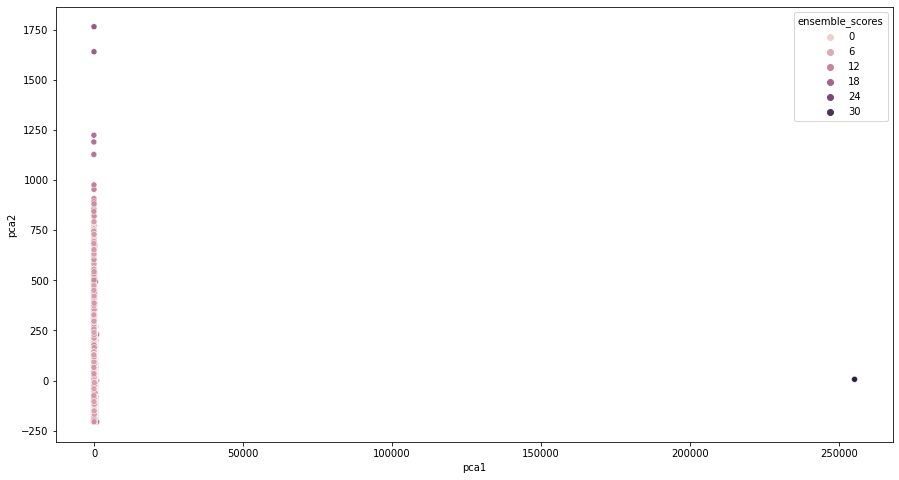

In [48]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data = anomalies_df,
    x = 'pca1', 
    y = 'pca2', 
    hue = "ensemble_scores",
)

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

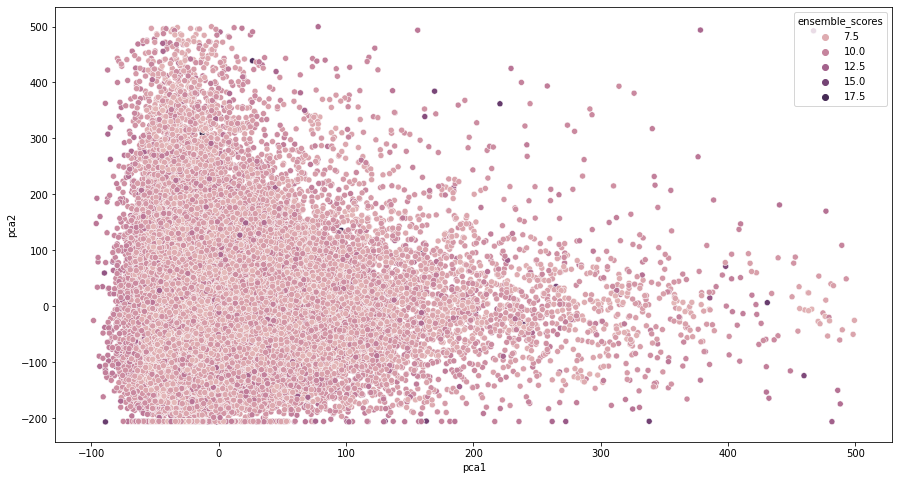

In [56]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data = anomalies_df[
        (anomalies_df.pca2 < 500) & 
        (anomalies_df.pca1 < 500) &
        (anomalies_df.pca1 > -100)
    ],
    x = 'pca1', 
    y = 'pca2', 
    hue = "ensemble_scores",
)

# PCA without scaling

In [52]:
for attribute in attributes:
    anomalies_df[attribute + '_norm'] = (anomalies_df[attribute] - anomalies_df[attribute].mean())/anomalies_df[attribute].std()

In [53]:
n_pca = PCA(n_components=2)
n_pca.fit(anomalies_df[[attribute + '_norm' for attribute in attributes]])

PCA(n_components=2)

In [54]:
n_pca.explained_variance_ratio_

array([0.1826587 , 0.16818537])

In [55]:
n_pca.singular_values_

array([499.24453424, 479.05706127])

In [57]:
n_pca.n_features_in_

20

In [58]:
n_pca.feature_names_in_

array(['glucose_norm', 'hemoglobin_norm', 'anion_gap_norm',
       'bicarbonate_norm', 'calcium_total_norm', 'chloride_norm',
       'creatinine_norm', 'magnesium_norm', 'phosphate_norm',
       'potassium_norm', 'sodium_norm', 'urea_nitrogen_norm',
       'hematocrit_norm', 'mch_norm', 'mchc_norm', 'mcv_norm',
       'platelet_count_norm', 'rdw_norm', 'red_blood_cells_norm',
       'white_blood_cells_norm'], dtype=object)

In [59]:
anomalies_n_pca = n_pca.transform(anomalies_df[[attribute + '_norm' for attribute in attributes]])

In [60]:
anomalies_n_pca1 = [row[0] for row in anomalies_n_pca]

In [61]:
anomalies_n_pca2 = [row[1] for row in anomalies_n_pca]

In [62]:
anomalies_df['n_pca1'] = anomalies_n_pca1

In [63]:
anomalies_df['n_pca2'] = anomalies_n_pca2

In [64]:
anomalies_df.head()

,hadm_id,glucose,hemoglobin,anion_gap,bicarbonate,calcium_total,chloride,creatinine,magnesium,phosphate,...,hematocrit_norm,mch_norm,mchc_norm,mcv_norm,platelet_count_norm,rdw_norm,red_blood_cells_norm,white_blood_cells_norm,n_pca1,n_pca2
0,1,286.5,13.05,27.0,23.500000,8.55,84.000000,3.85,2.1,6.65,...,1.392758,-0.600583,-0.360442,-0.314851,-0.982529,2.172946,1.507662,0.166821,0.897719,-3.820313
1,2,180.6,11.24,16.0,22.333333,0.00,100.333333,0.70,2.3,3.50,...,-0.004869,0.326487,0.400236,0.091341,0.373536,-1.012733,0.083822,-0.217707,-0.177100,1.097893
2,3,1000.0,0.00,0.0,0.000000,0.00,0.000000,0.00,0.0,0.00,...,-5.338782,-8.665222,-11.388536,-9.428128,-1.998363,-5.899808,-4.903023,-1.269367,19.489443,19.953180
3,4,0.0,0.00,0.0,0.000000,0.00,0.000000,0.95,2.1,0.00,...,2.539250,-8.665222,-11.388536,-9.428128,-0.199997,-5.899808,-4.903023,-0.667095,13.815271,12.289017
4,5,138.5,12.70,14.5,23.000000,9.50,104.500000,0.70,1.9,3.70,...,0.688485,0.140492,0.629482,-0.314851,1.122045,-0.689033,0.819586,-0.122733,-1.491881,0.067854


<AxesSubplot:xlabel='n_pca1', ylabel='n_pca2'>

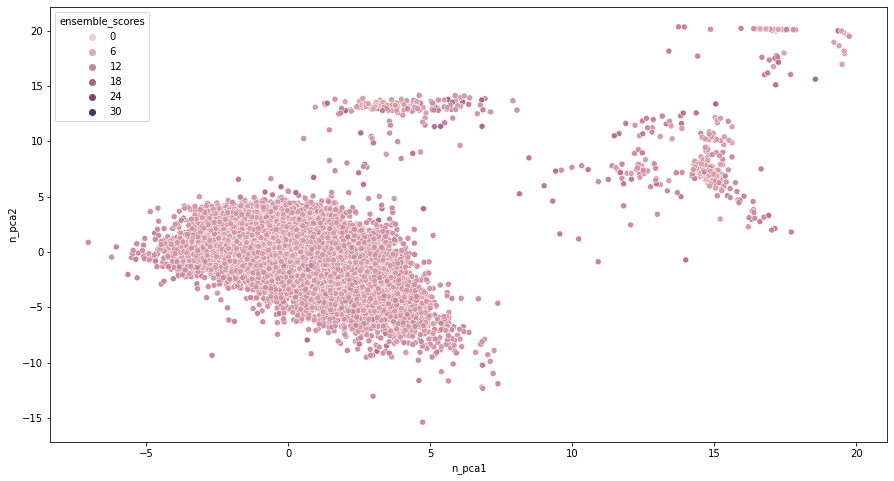

In [65]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data = anomalies_df,
    x = 'n_pca1', 
    y = 'n_pca2', 
    hue = "ensemble_scores",
)

# Missing values

In [66]:
anomalies_df['is_missing'] = [False] * anomalies_df.shape[0]

In [67]:
for attribute in attributes:
    anomalies_df['is_missing'] = (anomalies_df['is_missing']) | (anomalies_df[attribute] == 0)

In [68]:
anomalies_df.groupby('is_missing')['ensemble_scores'].mean()

is_missing
False    8.202808
True     8.667759
Name: ensemble_scores, dtype: float64

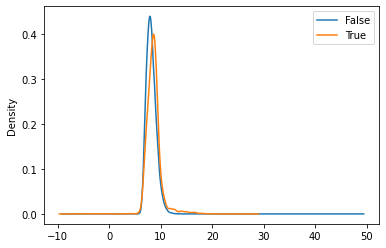

In [69]:
fig, ax = plt.subplots()

for key, grp in anomalies_df.groupby('is_missing')['ensemble_scores']:
    ax = grp.plot(ax=ax, kind='density', x='ensemble_scores', label=key)

plt.legend(loc='best')
plt.show()

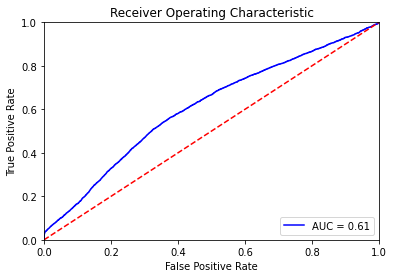

In [70]:
fpr, tpr, threshold = metrics.roc_curve(
    anomalies_df['is_missing'],
    anomalies_df['ensemble_scores'], 
)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

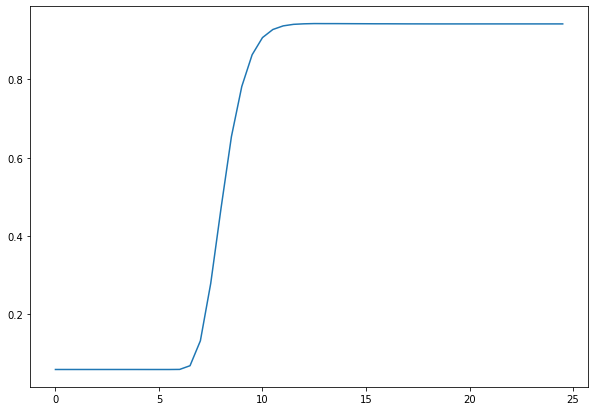

In [71]:
x = []
y = []
for i in np.arange(0, 25, 0.5):
    x.append(i)
    y.append(metrics.accuracy_score(
        anomalies_df['is_missing'], 
        (anomalies_df['ensemble_scores'] > i)
    ))

plt.figure(figsize=(10,7))
plt.plot(x, y)

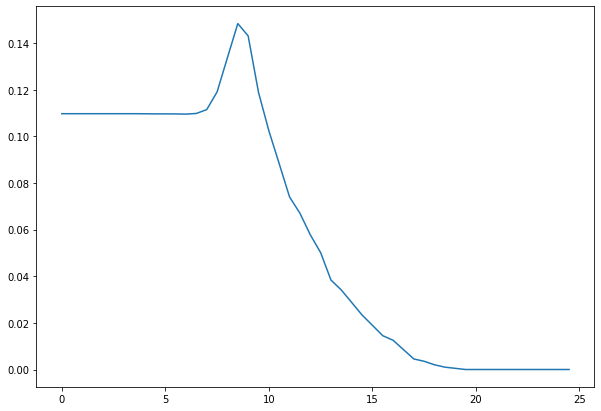

In [72]:
x = []
y = []
for i in np.arange(0, 25, 0.5):
    x.append(i)
    y.append(metrics.f1_score(
        anomalies_df['is_missing'], 
        (anomalies_df['ensemble_scores'] > i)
    ))

plt.figure(figsize=(10,7))
plt.plot(x, y)

# Outliers

In [73]:
anomalies_df['is_outlier'] = [False] * anomalies_df.shape[0]

In [74]:
for attribute in attributes:
    q1 = anomalies_df[attribute].quantile(0.25)
    q3 = anomalies_df[attribute].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    anomalies_df['is_outlier'] = (anomalies_df['is_outlier']) | (anomalies_df[attribute] < fence_low) | (anomalies_df[attribute] > fence_high)

In [75]:
anomalies_df.groupby('is_outlier')['ensemble_scores'].mean()

is_outlier
False    7.841699
True     8.754231
Name: ensemble_scores, dtype: float64

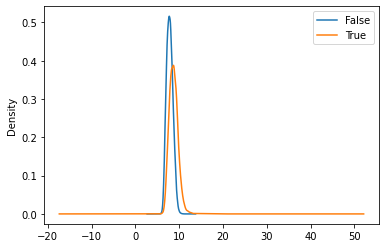

In [76]:
fig, ax = plt.subplots()

for key, grp in anomalies_df.groupby('is_outlier')['ensemble_scores']:
    ax = grp.plot(ax=ax, kind='density', x='ensemble_scores', label=key)

plt.legend(loc='best')
plt.show()

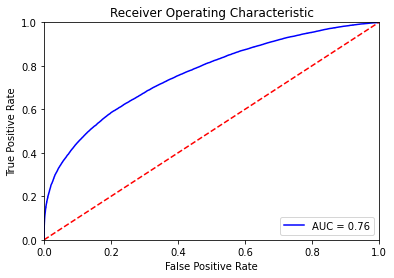

In [77]:
fpr, tpr, threshold = metrics.roc_curve(
    anomalies_df['is_outlier'],
    anomalies_df['ensemble_scores'], 
)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

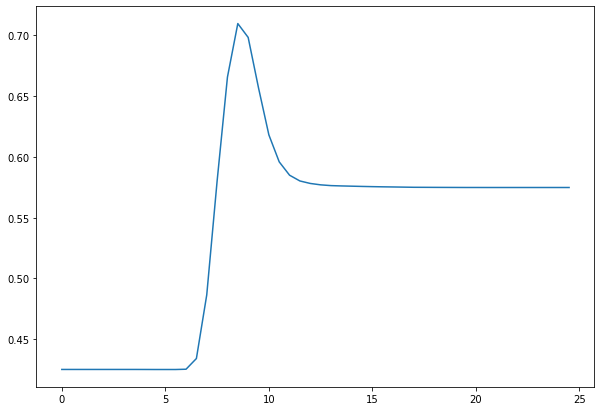

In [78]:
x = []
y = []
for i in np.arange(0, 25, 0.5):
    x.append(i)
    y.append(metrics.accuracy_score(
        anomalies_df['is_outlier'], 
        (anomalies_df['ensemble_scores'] > i)
    ))

plt.figure(figsize=(10,7))
plt.plot(x, y)

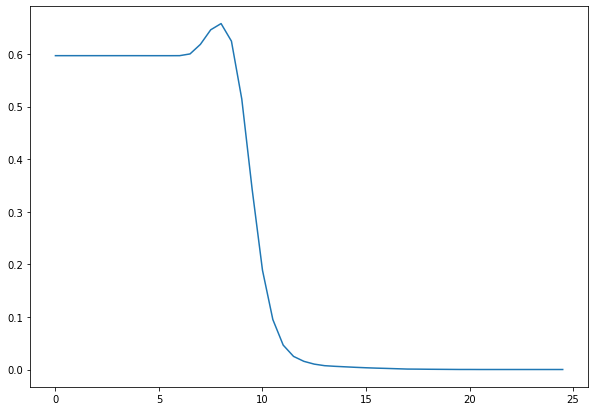

In [79]:
x = []
y = []
for i in np.arange(0, 25, 0.5):
    x.append(i)
    y.append(metrics.f1_score(
        anomalies_df['is_outlier'], 
        (anomalies_df['ensemble_scores'] > i)
    ))

plt.figure(figsize=(10,7))
plt.plot(x, y)

In [85]:
sum(anomalies_df[anomalies_df['ensemble_scores'] > 8]['is_outlier'])/sum(anomalies_df['is_outlier'])

0.7560395630147845

<AxesSubplot:>

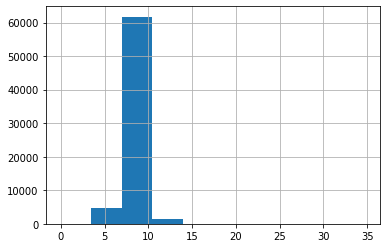

In [86]:
anomalies_df['ensemble_scores'].hist()